# Random Forest and noise variables

As random forest looks at only a subset of the features for each split (for classification, typically $\sqrt{d}$, where $d$ is the number of features), noise variables may have a detrimental effect. Let's check!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss
import pandas as pd
import seaborn as sns
plt.style.use("seaborn-v0_8")

Two imports of note here: pandas, a library to handle data in tabular form, and seaborn, a library for nice looking statistical plots.

We generate a toy data set in two dimensions. We choose a large test set so that the test error will be close to the true error.

<Figure size 432x432 with 0 Axes>

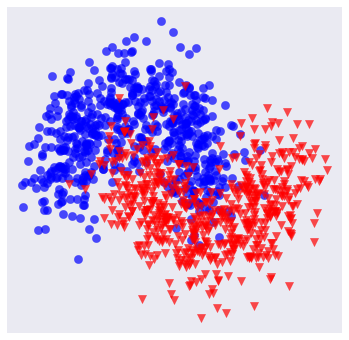

In [2]:
train_size=200
test_size=1000
X,y=make_moons(n_samples=train_size+test_size,noise=0.3) ## make_moons generates a toy dataset, see https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html

plt.figure(figsize=(6,6))
_,ax=plt.subplots(figsize=(6,6))
ax.scatter(X[y==0,0],X[y==0,1],color='blue',marker='o',s=70,alpha=0.7)
ax.scatter(X[y==1,0],X[y==1,1],color='red',marker='v',s=70,alpha=0.7)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Now, we add noise variables (features) to the training and test set. That is, we generate random noise and simply add it to the data set. Clearly, these noise features do not help to distinguish the two classes. We now fit and evaluate a random forest classifier for different numbers of noise variables, where we repeat each fit 100 times to gain some statistical stability. We also compare with AdaBoost. 

Note how we keep track of the results: we simply record all the parameters of the experiment and append this record to a list. Because it's nicer to handle we turn this list into Pandas DataFrame.

In [3]:
n_estimators=100
rf=RandomForestClassifier(n_estimators=n_estimators)
ada=AdaBoostClassifier(n_estimators=n_estimators)

noise_sizes=range(10,201,10)

def get_errors(classifier,X,y,train_size):
    X_train,X_test=X[:train_size],X[train_size:]
    y_train,y_test=y[:train_size],y[train_size:]
    classifier.fit(X_train,y_train)
    train_err=zero_one_loss(y_train,classifier.predict(X_train))
    test_err=zero_one_loss(y_test,classifier.predict(X_test))
    return train_err,test_err

noise_sizes=range(10,201,10)
result_table=[]
repeats=100
for noise_size in noise_sizes:
    size=(X.shape[0],noise_size)
    for r in range(repeats):
        noise=np.random.normal(size=size)
        X_with_noise=np.hstack([X,noise])
        train_err_with_noise,test_err_with_noise = get_errors(rf,X_with_noise,y,train_size)
        result_table.append(['rf',r+1,noise_size,train_err_with_noise,test_err_with_noise])
        train_err_with_noise,test_err_with_noise = get_errors(ada,X_with_noise,y,train_size)
        result_table.append(['ada',r+1,noise_size,train_err_with_noise,test_err_with_noise])

result=pd.DataFrame(result_table,columns=['algorithm','repeat_num','#noise vars','train error','test error'])
# let's save the data as it takes a while to compute it
result.to_csv("rf_noise_vars.csv")

Let's have a peek at the resulting table:

In [4]:
result.head()

,algorithm,repeat_num,#noise vars,train error,test error
0,rf,1,10,0.0,0.141
1,ada,1,10,0.0,0.124
2,rf,2,10,0.0,0.126
3,ada,2,10,0.0,0.138
4,rf,3,10,0.0,0.146


In [5]:
result['train error'].max()

0.0

Aha, every instance of random forest and AdaBoost was able to fit the training set perfectly.

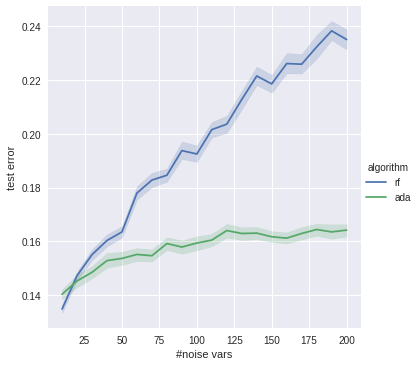

In [6]:
sns.relplot(x="#noise vars",y="test error",kind="line",data=result,hue='algorithm')
plt.savefig("rf_noise_vars.png",dpi=300,bbox_inches='tight',pad_inches=0.1)

The plot shows the means as well as a 95% confidence interval. We see that while both algorithms are affected by the noise variables, the effect is much more pronounced for random forest. Interestingly, we do not see smooth curves, and in particular for random forest, the test error sometimes drops with more noise variables. This may be a rounding effect: it may be that the number of features for the split is chosen as $\lfloor \sqrt{d}\rfloor$.

A single decision tree in random forest does not use all the features available but only a random selection of $\sqrt d$ of the $d$ features. Thus, if there are many noise variables then the probability that one of the two _true_ features is chosen is small. In fact, for $m=\sqrt d$ the probability is 
$$
\frac{2m(d-m)+m(m-1)}{d(d-1)}
$$

Let's plot this.

In [7]:
def pick_proba(noise_size):
    d=2+noise_size
    m=d**0.5
    return m*(2*(d-m)+m-1)/d/(d-1)

Text(0, 0.5, 'probability to pick at least one true feature')

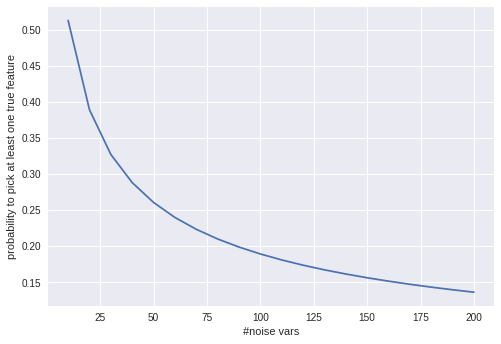

In [8]:
_,ax=plt.subplots()
ax.plot(noise_sizes,[pick_proba(n) for n in noise_sizes])
ax.set_xlabel("#noise vars")
ax.set_ylabel("probability to pick at least one true feature")

**Conclusion:** if we work with a data set with many features that are only very loosely coupled to the class then we may need to clean these features first before applying random forest (or use another classifying algorithm).